In [11]:
# Imports

import pickle

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import matplotlib.pyplot as plt
from torchtext.data.metrics import bleu_score

In [3]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
%cd drive/MyDrive/CSE-676
%ls

/content/drive/MyDrive/CSE-676
data/  helpers/  images/  models/  seq2seq.ipynb


In [5]:
# Helper functions

from helpers.preprocessing import preprocess_data, split_data
from helpers.model import Encoder, AttentionDecoder
from helpers.training import prepare_dataloader, train
from helpers.evaluation import generate_translation, evaluate

In [6]:
# Global Variables

languages = ['eng', 'fra', 'spa', 'deu', 'por']
LANGUAGE1 = languages[0]
LANGUAGE2 = languages[1]
FILEPATH = f'data/{LANGUAGE1}-{LANGUAGE2}.txt'

# Model tuning parameters

HIDDEN_SIZE = 128
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT = 0.1

Data preprocessing

In [7]:
input_language, output_language, line_pairs = preprocess_data(FILEPATH, LANGUAGE1, LANGUAGE2)

train_pairs, test_pairs = split_data(line_pairs, test_size=0.2)

Number of translation pairs: 17917
fra 5699
eng 3703
Number of training pairs: 14333
Number of testing pairs: 3584


Model

In [8]:
# TODO

# basic, gru, lstm, decoder without attention, diff attension mechanism

In [9]:
encoder = Encoder(input_language.n_words, HIDDEN_SIZE, DROPOUT).to(device)
decoder = AttentionDecoder(HIDDEN_SIZE, output_language.n_words, DROPOUT).to(device)

encoder, decoder

(Encoder(
   (encoder_layers): Sequential(
     (0): Embedding(5699, 128)
     (1): Dropout(p=0.1, inplace=False)
     (2): GRU(128, 128, batch_first=True)
   )
 ),
 AttentionDecoder(
   (embedding): Embedding(3703, 128)
   (attention): BahdanauAttention(
     (Wa): Linear(in_features=128, out_features=128, bias=True)
     (Ua): Linear(in_features=128, out_features=128, bias=True)
     (Va): Linear(in_features=128, out_features=1, bias=True)
   )
   (gru): GRU(256, 128, batch_first=True)
   (out): Linear(in_features=128, out_features=3703, bias=True)
   (dropout): Dropout(p=0.1, inplace=False)
 ))

Training

In [10]:
input_language, output_language, train_dataloader = prepare_dataloader(input_language, output_language, train_pairs, BATCH_SIZE)

losses_list, accuracies_list = train(train_dataloader, encoder, decoder, LEARNING_RATE, epochs=10, print_result=2)

Training...
Epoch [2/10], Average Loss: 2.0494, Average Accuracy: 0.4943
Epoch [4/10], Average Loss: 1.2411, Average Accuracy: 0.6472
Epoch [6/10], Average Loss: 0.9029, Average Accuracy: 0.7195
Epoch [8/10], Average Loss: 0.6799, Average Accuracy: 0.7747
Epoch [10/10], Average Loss: 0.5205, Average Accuracy: 0.8197


In [12]:
print(losses_list)
print(accuracies_list)

[2.4550217060106143, 1.643691443705133, 1.3488415870815516, 1.133455356050815, 0.9693359429282802, 0.8364630926932607, 0.7258302412394967, 0.6340270591234523, 0.5531254799903503, 0.4879607642069459]
[0.4181059004111074, 0.5704947243004197, 0.6247329948584739, 0.6696542618850831, 0.7044105492523856, 0.7345298026040381, 0.763060442450329, 0.7862778141536876, 0.8096454601075534, 0.8296963386752252]


Save Model

In [13]:
# Save models

encoder_filepath = f'models/encoder-{LANGUAGE1}-{LANGUAGE2}.pth'
decoder_filepath = f'models/decoder-{LANGUAGE1}-{LANGUAGE2}.pth'

torch.save(encoder.state_dict(), encoder_filepath)
torch.save(decoder.state_dict(), decoder_filepath)

# Load models

# encoder.load_state_dict(torch.load(encoder_filepath))
# decoder.load_state_dict(torch.load(decoder_filepath))

Save Lists

In [18]:
# Save list as a pickle object

loss_filename = f'objects/loss_{LANGUAGE2}_{LANGUAGE1}.pkl'
accuracy_filename = f'objects/accuracy_{LANGUAGE2}_{LANGUAGE1}.pkl'

with open(loss_filename, 'wb') as file:
    pickle.dump(losses_list, file)

with open(accuracy_filename, 'wb') as file:
    pickle.dump(losses_list, file)

# Load pickle object back into a list

# with open(loss_filename, 'rb') as file:
#     loss_filename = pickle.load(file)

# with open(accuracy_filename, 'rb') as file:
#     accuracy_filename = pickle.load(file)

# loss_filename, accuracy_filename

Evaluation

In [ ]:
# Evaluate random training pairs

encoder.eval()
decoder.eval()

references_corpus, candidate_corpus = evaluate(input_language, output_language, encoder, decoder,
                                               train_pairs, evaluate_train=True)

Input Sequence> ils epandent les arbres fruitiers
Target Sequence = ['they', 'are', 'spraying', 'the', 'fruit', 'trees']
Predicted sequence < ['they', 'are', 'spraying', 'the', 'fruit', 'trees']
Input Sequence> je suis desole si je vous ai embarrasse
Target Sequence = ['i', 'm', 'sorry', 'if', 'i', 'embarrassed', 'you']
Predicted sequence < ['i', 'm', 'sorry', 'if', 'i', 'embarrassed', 'you']
Input Sequence> elle aime prendre des photos
Target Sequence = ['she', 's', 'fond', 'of', 'taking', 'pictures']
Predicted sequence < ['she', 's', 'fond', 'of', 'taking', 'pictures']
Input Sequence> ce sont des traitres
Target Sequence = ['they', 're', 'traitors']
Predicted sequence < ['they', 're', 'traitors']
Input Sequence> je mange votre chocolat
Target Sequence = ['i', 'm', 'eating', 'your', 'chocolate']
Predicted sequence < ['i', 'm', 'eating', 'your', 'chocolate']
Input Sequence> je suis desole mon pere n est pas la
Target Sequence = ['i', 'm', 'sorry', 'my', 'father', 's', 'not', 'here']
Pr

In [ ]:
# Evaluate testing pairs

candidate_corpus, references_corpus = evaluate(input_language, output_language, encoder, decoder,
                                                test_pairs, evaluate_train=False, iterations=len(test_pairs))

Streaming output truncated to the last 5000 lines.
Target Sequence = ['we', 're', 'all', 'disappointed']
Predicted sequence < ['we', 're', 'all', 'happy', 'aren', 't', 'happy']
Input Sequence> nous sommes tous en securite
Target Sequence = ['we', 're', 'all', 'safe']
Predicted sequence < ['we', 're', 'all', 'safe']
Input Sequence> je suis encore en ville
Target Sequence = ['i', 'm', 'still', 'in', 'town']
Predicted sequence < ['i', 'm', 'still', 'in', 'town', 'town']
Input Sequence> c est une chanteuse pas banale
Target Sequence = ['she', 'is', 'no', 'ordinary', 'singer']
Predicted sequence < ['she', 's', 'a', 'single', 'mother']
Input Sequence> je dis la verite tom
Target Sequence = ['i', 'm', 'telling', 'the', 'truth', 'tom']
Predicted sequence < ['i', 'm', 'truthful']
Input Sequence> il a trois ans de plus que moi
Target Sequence = ['he', 's', 'three', 'years', 'older', 'than', 'me']
Predicted sequence < ['he', 's', 'three', 'years', 'older', 'than', 'i', 'am']
Input Sequence> nous 

Benchmark

In [ ]:
bleu = bleu_score(candidate_corpus, references_corpus)

bleu

0.4878530204296112

Analysis

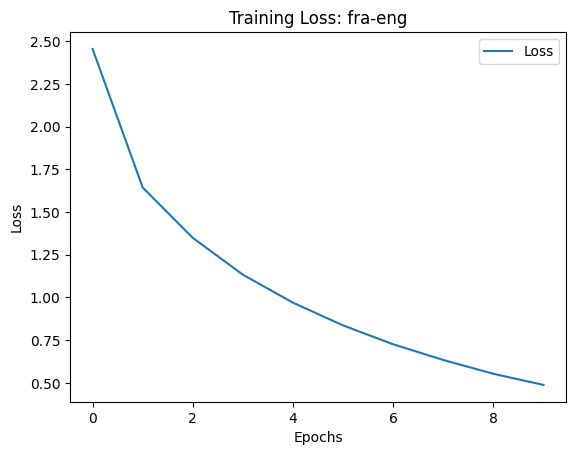

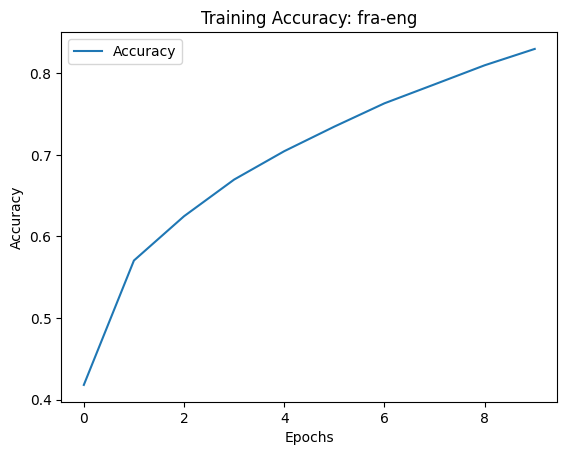

In [22]:
# Plot loss
plt.plot(losses_list, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Training Loss: {LANGUAGE2}-{LANGUAGE1}')
plt.savefig(f'images/loss_{LANGUAGE2}_{LANGUAGE1}.png')  # Save the loss plot as an image
plt.show()
plt.close()  # Close the plot to start a new one

# Plot accuracy
plt.plot(accuracies_list, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Training Accuracy: {LANGUAGE2}-{LANGUAGE1}')
plt.savefig(f'images/accuracy_{LANGUAGE2}_{LANGUAGE1}.png')  # Save the accuracy plot as an image
plt.show()
plt.close()  # Close the plot